In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import utils
import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

In [2]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1'
variables = ['NO3','SiO3','PO4']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time_bound']
path

'/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1'

### get monthly data

In [3]:
def preprocess(ds):
    ds=ds.isel(z_t=0)
    #ds=ds.isel(z_t_150m=0)
    return ds

In [4]:
%%time

ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.195801-202112.nc'))

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                   drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

    ds = xr.merge((ds, dsv))

ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()

NO3
SiO3
PO4
CPU times: user 1.18 s, sys: 82.4 ms, total: 1.26 s
Wall time: 2.39 s


In [5]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [6]:
ds

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 768)
Coordinates:
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time        (time) object 1958-01-16 13:00:00.000001 ... 2021-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    KMT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    NO3         (time, nlat, nlon) float32 dask.array<chunksize=(768, 384, 320), meta=np.ndarray>
    dz          float32 dask.array<chunksize=(), meta=np.ndarray>
    time_bound  (time, d2) object dask.array<chunksize=(768, 2), meta=np.ndarray>
    SiO3        (time, nlat, nlon) float32 dask.array<chunksize=(768, 384, 320), meta=np.ndarray>
    PO4         (time, nlat, nlon) float32 dask.array<chunksize=(768, 384, 320), meta=np.ndarray>

### spin up some dask to make the processing faster

In [7]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='25GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [8]:
cluster, client = get_ClusterClient()
cluster.scale(8) 

In [9]:
client

Client Scheduler: tcp://128.117.208.83:36141 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Make annual means

In [10]:
ds_ann = ds.resample({'time':'A'}).mean(dim='time').compute()

### Trim it to the same years as the hi res comparison: 1997 to 2018

In [11]:
ds_ann.time[39:61]

<xarray.DataArray 'time' (time: 22)>
array([cftime.DatetimeNoLeap(1997, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1998, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1999, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2000, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2001, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2003, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2004, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2005, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2006, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2007, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2008, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2009, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2010, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2011, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2012, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2013, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2014, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2015, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2016, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2017, 12, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2018, 12, 31, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1997-12-31 00:00:00 ... 2018-12-31 00:00:00

In [12]:
ds_ann = ds_ann.isel(time=slice(39,61))

In [13]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

area = ds_grid.TAREA
lats = ds_grid.TLAT
lons = ds_grid.TLONG

### Make a mean over time

In [14]:
ds = ds_ann.mean(dim='time')

In [15]:
ds

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320)
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 -79.22 ... nan nan nan
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... nan nan nan nan
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT      (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    NO3      (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    dz       float32 1e+03
    SiO3     (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan
    PO4      (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan nan

### Get WOA data

In [16]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [17]:
ds_woa = ds_woa.isel(z_t=0)

In [18]:
ds_woa

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_w: 60, z_w_bot: 60)
Coordinates:
    z_t          float64 500.0
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables: (12/17)
    TEMP         (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
    SALT         (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
    NO3          (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
    O2           (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
    SiO3         (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
    PO4          (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
    ...           ...
    DXT          (nlat, nlon) float64 2.339e+06 2.339e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    TAREA        (nlat, nlon) float64 1.39e+13 1.39e+13 ... 7.431e+12 7.432e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           float64 1e+03
Attributes:
    history:  created by kristen krumhardt on 2019-10-25

In [19]:
#ds_woa['z_t'] = ds.z_t

NO3_diff = ds.NO3 - ds_woa.NO3
PO4_diff = ds.PO4 - ds_woa.PO4
SiO3_diff = ds.SiO3 - ds_woa.SiO3

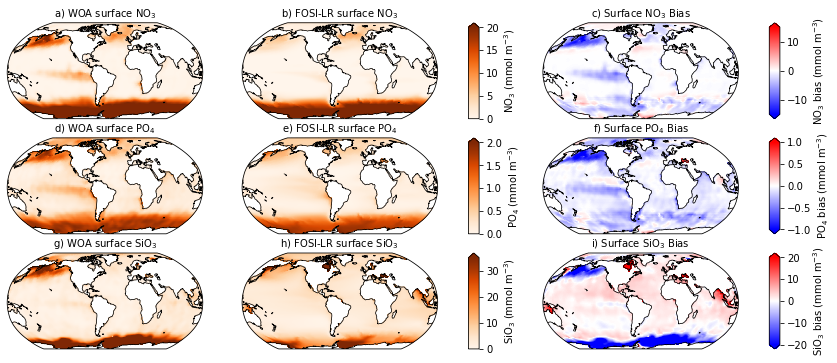

In [20]:
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(nrows=3, ncols=6, width_ratios=(1, 1, 0.05, 0.05, 1, 0.05))

prj = ccrs.Robinson(central_longitude=305.0)

ax_no3_woa = plt.subplot(gs[0, 0], projection=prj)
ax_no3_cesm = plt.subplot(gs[0, 1], projection=prj)
cax_no3 = plt.subplot(gs[0, 2])
ax_no3_diff = plt.subplot(gs[0, 4], projection=prj)
cax_no3_diff = plt.subplot(gs[0, 5])

ax_po4_woa = plt.subplot(gs[1, 0], projection=prj)
ax_po4_cesm = plt.subplot(gs[1, 1], projection=prj)
cax_po4 = plt.subplot(gs[1, 2])
ax_po4_diff = plt.subplot(gs[1, 4], projection=prj)
cax_po4_diff = plt.subplot(gs[1, 5])

ax_si_woa = plt.subplot(gs[2, 0], projection=prj)
ax_si_cesm = plt.subplot(gs[2, 1], projection=prj)
cax_si = plt.subplot(gs[2, 2])
ax_si_diff = plt.subplot(gs[2, 4], projection=prj)
cax_si_diff = plt.subplot(gs[2, 5])


### NO3 row
ax_no3_woa.set_title('a) WOA surface NO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_woa.NO3)
pc1=ax_no3_woa.pcolormesh(lon, lat,field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_no3_woa.coastlines('110m',linewidth=0.75)

ax_no3_cesm.set_title('b) FOSI-LR surface NO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds.NO3)
pc1=ax_no3_cesm.pcolormesh(lon, lat,field, vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_no3_cesm.coastlines('110m',linewidth=0.75)

cb_no3 = plt.colorbar(pc1, cax=cax_no3,extend='max', 
                      label='NO$_3$ (mmol m$^{-3}$)')

ax_no3_diff.set_title('c) Surface NO$_3$ Bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, NO3_diff)
pc1=ax_no3_diff.pcolormesh(lon, lat,field, vmin=-15, vmax=15, cmap='bwr',
                 transform=ccrs.PlateCarree())
ax_no3_diff.coastlines('110m',linewidth=0.75)

cb_no3_diff = plt.colorbar(pc1, cax=cax_no3_diff,extend='both', 
                      label='NO$_3$ bias (mmol m$^{-3}$)')


### PO4 row
ax_po4_woa.set_title('d) WOA surface PO$_4$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_woa.PO4)
pc1=ax_po4_woa.pcolormesh(lon, lat,field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_po4_woa.coastlines('110m',linewidth=0.75)

ax_po4_cesm.set_title('e) FOSI-LR surface PO$_4$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds.PO4)
pc1=ax_po4_cesm.pcolormesh(lon, lat, field, vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_po4_cesm.coastlines('110m',linewidth=0.75)

cb_po4 = plt.colorbar(pc1, cax=cax_po4,extend='max', 
                      label='PO$_4$ (mmol m$^{-3}$)')

ax_po4_diff.set_title('f) Surface PO$_4$ Bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, PO4_diff)
pc1=ax_po4_diff.pcolormesh(lon, lat,field, vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
ax_po4_diff.coastlines('110m',linewidth=0.75)

cb_po4_diff = plt.colorbar(pc1, cax=cax_po4_diff,extend='both', 
                      label='PO$_4$ bias (mmol m$^{-3}$)')


### SiO3 row
ax_si_woa.set_title('g) WOA surface SiO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_woa.SiO3)
pc1=ax_si_woa.pcolormesh(lon, lat,field, vmin=0, vmax=35, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_si_woa.coastlines('110m',linewidth=0.75)

ax_si_cesm.set_title('h) FOSI-LR surface SiO$_3$', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds.SiO3)
pc1=ax_si_cesm.pcolormesh(lon, lat, field, vmin=0, vmax=35, cmap='Oranges',
                 transform=ccrs.PlateCarree())
ax_si_cesm.coastlines('110m',linewidth=0.75)

cb_si = plt.colorbar(pc1, cax=cax_si,extend='max', 
                      label='SiO$_3$ (mmol m$^{-3}$)')

ax_si_diff.set_title('i) Surface SiO$_3$ Bias', fontsize=10)
lon, lat, field = utils.adjust_pop_grid(lons, lats, SiO3_diff)
pc1=ax_si_diff.pcolormesh(lon, lat, field, vmin=-20, vmax=20, cmap='bwr',
                 transform=ccrs.PlateCarree())
ax_si_diff.coastlines('110m',linewidth=0.75)

cb_si_diff = plt.colorbar(pc1, cax=cax_si_diff,extend='both', 
                      label='SiO$_3$ bias (mmol m$^{-3}$)')

fig.savefig('/glade/work/kristenk/figs/nuts_validation_x1.png', bbox_inches='tight', dpi=300, format='png');

In [21]:
cluster.close()